## Q2.1 Creating Dataset

#### Importing Libraries and basic setup

In [1]:
# importing the required libraries
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### GPU Setup

In [2]:
# checking pytorch version
print(torch.__version__)

2.2.0


In [3]:
import torchvision
# checking if cuda is available
torch.cuda.is_available()

True

In [4]:
# setting the device to cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# File handling
current_path = os.getcwd()
new_path = os.path.join(current_path, 'Cropped_final\Cropped_final')
os.chdir(new_path)
for i in os.listdir():
    print(i)

amur_leopard
amur_tiger
birds
black_bear
brown_bear
dog
people
roe_deer
sika_deer
wild_boar


#### Dataset Class

In [6]:
class RussianWildLifeDataset(Dataset):
  def __init__(self, root_dir, transform):
    self.transform = transform
    self.root_dir = root_dir
    self.classes = os.listdir(self.root_dir)
    self.classes.sort()
    self.class_index_mapping = dict(zip(range(len(self.classes)), self.classes))
    self.__load_data__()
    self.num_classes = torch.unique(torch.tensor(self.labels)).size(0)
    
  def __load_data__(self):
    self.images_filenames = []
    self.labels = []
    for i in range(len(self.class_index_mapping)):
      # go to the class directory
      os.chdir(new_path)
      class_path = os.path.join(self.root_dir, self.class_index_mapping[i])
      for image in os.listdir(class_path):
        self.images_filenames.append(os.path.join(class_path, image))
        self.labels.append(i)

  def get_class_name(self, label):
    return self.class_index_mapping[label]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = im.open(self.images_filenames[idx])
    label = self.labels[idx]
    if (self.transform):
      image = self.transform(image)
    label_value = label
    sample = {'image': image, 'label': label}
    return sample

#### Transforms

In [7]:
composed_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### Dataloader splitting

In [8]:
train_size = 0.7
val_size = 0.1
test_size = 0.2
batch_size = 16
run_num = 1

In [9]:
dataset = RussianWildLifeDataset(new_path, composed_transform)

In [10]:
class_wise_indices = [np.where(np.array(dataset.labels) == i)[0] for i in range(len(dataset.classes))]
class_distribution = [len(indices) for indices in class_wise_indices]
train_class_distribution = [int(train_size * dist) for dist in class_distribution]
val_class_distribution = [int(val_size * dist) for dist in class_distribution]
test_class_distribution = [int(test_size * dist) for dist in class_distribution]

In [11]:
train_indices = []
val_indices = []
test_indices = []
for i in range(len(dataset.classes)):
    np.random.shuffle(class_wise_indices[i])
    train_indices.extend(class_wise_indices[i][:train_class_distribution[i]])
    val_indices.extend(class_wise_indices[i][train_class_distribution[i]:train_class_distribution[i]+val_class_distribution[i]])
    test_indices.extend(class_wise_indices[i][train_class_distribution[i]+val_class_distribution[i]:])

In [12]:
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [13]:
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)
print(train_size, val_size, test_size)

8973 1276 2576


#### Data Distribution Visualization

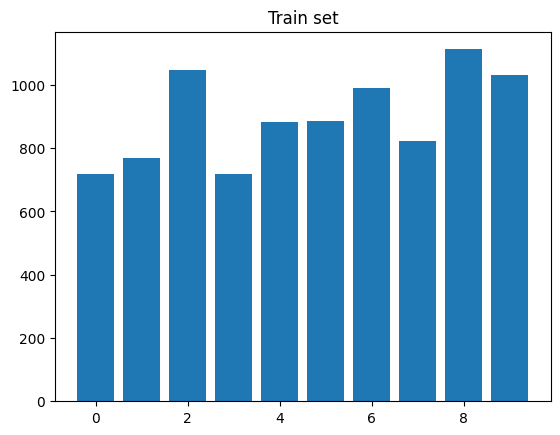

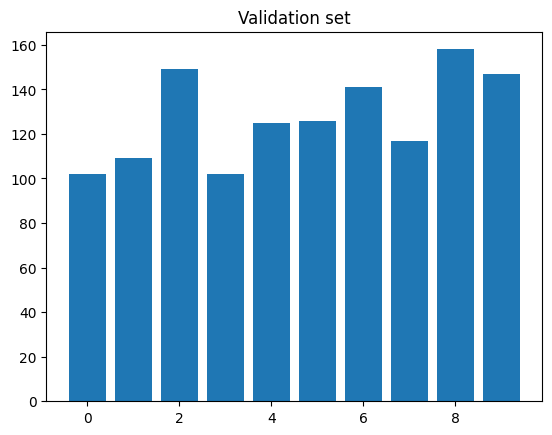

In [14]:
def plot_distribution(data, title):
  labels = [sample['label'] for sample in data]
  unique, counts = np.unique(labels, return_counts=True)
  plt.bar(unique, counts)
  plt.title(title)
  plt.show()

plot_distribution(train_data, 'Train set')
plot_distribution(val_data, 'Validation set')

#### WandB Setup

In [15]:
print(os.getcwd())
os.chdir("..")
os.chdir("..")
print(os.getcwd())

c:\Users\prakh\Prakhar\College\Semester 6\Computer Vision\A1\CV_Assignments\A1\Cropped_final\Cropped_final
c:\Users\prakh\Prakhar\College\Semester 6\Computer Vision\A1\CV_Assignments\A1


In [16]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prakhar432. Use `wandb login --relogin` to force relogin


True

In [17]:
model_config = dict(
    epochs=10,
    classes=10,
    kernels=[3, 3, 3],
    features=[32, 64, 128],
    batch_size=batch_size,
    optimizer="Adam",
    learning_rate=0.001,
    dataset="Russian WildLife Dataset",
    architecture="CNN", 
    weight_initialisation="Default")

In [18]:
wandb.init(
    project = "Computer_Vision_A1",
    config = model_config,
)

#### Data Visualization

In [19]:
def data_visualization(data):
    num_rows = 3
    num_cols = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,2*num_rows))
    for i in range(num_rows):
        for j in range(num_cols):
            sample = train_data[np.random.randint(0, len(train_data))]
            image, label = sample['image'], sample['label']
            image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
            axes[i, j].imshow(image)
            axes[i, j].set_title(dataset.get_class_name(label))
            axes[i, j].axis('off')
    plt.show()

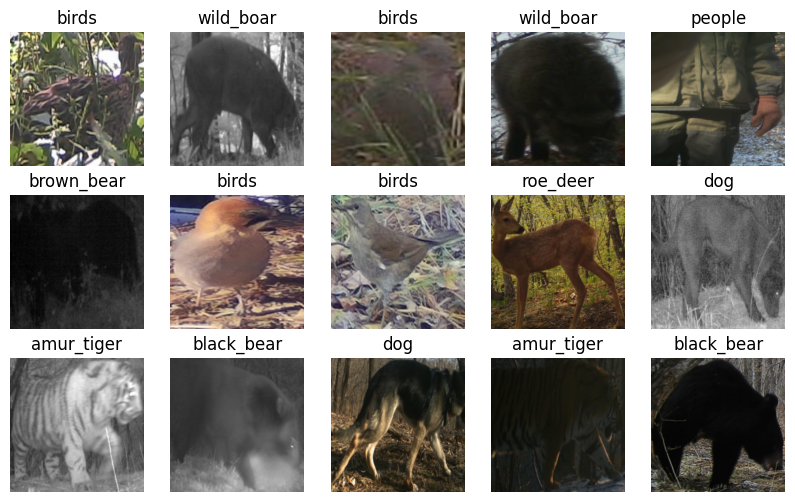

In [20]:
data_visualization(train_data)

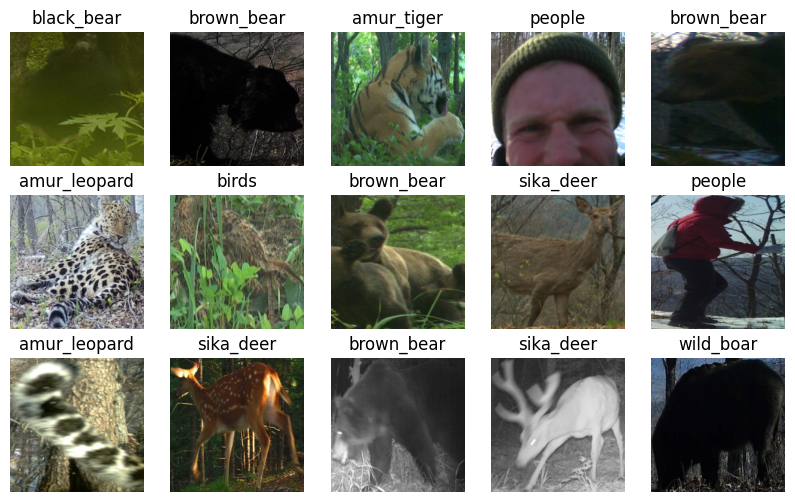

In [21]:
data_visualization(val_data)

## Q2.2 Training a CNN Model 

#### CNN Architecture and Model Definition

In [22]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        # First Convolutional Layer
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4)
    )
    self.conv_layer2 = nn.Sequential(
        # Second Convolutional Layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_layer3 = nn.Sequential(
        # Third Convolutional Layer
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fully_connected = nn.Sequential(
        nn.Linear(128*14*14, 10)
    )
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = torch.flatten(x, 1)
    logits = self.fully_connected(x)
    return logits

  def softmax(self, x):
    x = self.Softmax(x)
    return x

In [23]:
model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# move the model to the gpu
model.to(device)

ConvNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=25088, out_features=10, bias=True)
  )
  (Softmax): Softmax(dim=1)
)

#### Logging Function

In [35]:
def loss_acc_calc(dataloader):
  model.eval()
  with torch.no_grad():
    correct, total, loss = 0, 0, 0.0
    for i, sample in enumerate(dataloader, 0):
      images = sample['image']
      labels = sample['label']
      images = images.to(device)
      labels = torch.tensor(labels).to(device)
      forwards = model.forward(images)
      logits = model.softmax(forwards)
      preds = torch.argmax(logits, dim=1)
      correct += torch.eq(preds, labels).sum().item()
      total += labels.size(0)
      loss_val = loss_fn(forwards, labels)
      loss += loss_val.item()
  return correct, total, loss

#### Model Training

In [25]:
wandb.watch(model)

[]

In [26]:
def train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader):
    running_loss = 0.0
    model.train()
    for epoch in range(model_config['epochs']):
        for i, sample in enumerate(train_dataloader, 0):
            inputs = sample['image']
            labels = sample['label']
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)
            # zero the gradients before backprop
            optimizer.zero_grad()
            # forward pass
            logits = model.forward(inputs)
            loss = loss_fn(logits, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            minibatch_loss = loss.item()
            running_loss += minibatch_loss
            # logging the minibatch after every batch, and running loss after every 100 minibatches
            wandb.log({'minibatch_loss': minibatch_loss})
            if (i%100==0):
                wandb.log({'running_loss': running_loss / 100})
                running_loss = 0.0
        # log the training accuracy and loss
        correct, total, loss = loss_acc_calc(train_dataloader)
        wandb.log({'train_loss': loss / len(train_dataloader), 'train_accuracy': (correct / total) * 100.0})
        # log the validation accuracy and loss
        correct, total, loss = loss_acc_calc(val_dataloader)
        wandb.log({'val_loss': loss / len(val_dataloader), 'val_accuracy': (correct / total) * 100.0})
    # save the model after training
    torch.save(model.state_dict(), f"A1_Q2_ConvNet_Experiment_{run_num}.pth")
    return model

In [27]:
# training the model 
model = train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader)

#### Model Evaluation

In [28]:
def evaluation_metris_calc(dataloader):
    y_true = []
    y_pred = []
    for i, sample in enumerate(dataloader, 0):
        images = sample['image']
        labels = sample['label']
        images = images.to(device)
        labels = torch.tensor(labels).to(device)
        forwards = model.forward(images)
        logits = model.softmax(forwards)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

In [29]:
# testing the model 
correct, total, loss = loss_acc_calc(test_dataloader)
print(f"Test Accuracy: {(correct / total) * 100.0}%")
wandb.log({'test_accuracy': (correct / total) * 100.0})
# calculate the metrics
y_true, y_pred = evaluation_metris_calc(test_dataloader)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
# logging the metrics onto wandb
wandb.run.summary["test_accuracy"] = (correct / total) * 100.0
wandb.run.summary["f1_score"] = f1
wandb.run.summary["precision"] = precision
wandb.run.summary["recall"] = recall

Test Accuracy: 61.99534161490683%
F1 Score: 0.6212670705724778
Precision: 0.6312301149759185
Recall: 0.6199534161490683


#### Confusion Matrix 

In [31]:
def plotting_confusion_matrix(dataloader, file_name):
    # calculate the confusion matrix using sklearn 
    y_true, y_pred = evaluation_metris_calc(dataloader)
    cm = confusion_matrix(y_true, y_pred)
    # plot the confusion matrix with numbers
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=dataset.classes, yticklabels=dataset.classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    plt.show()
    # save the confusion matrix 
    fig.savefig(file_name)

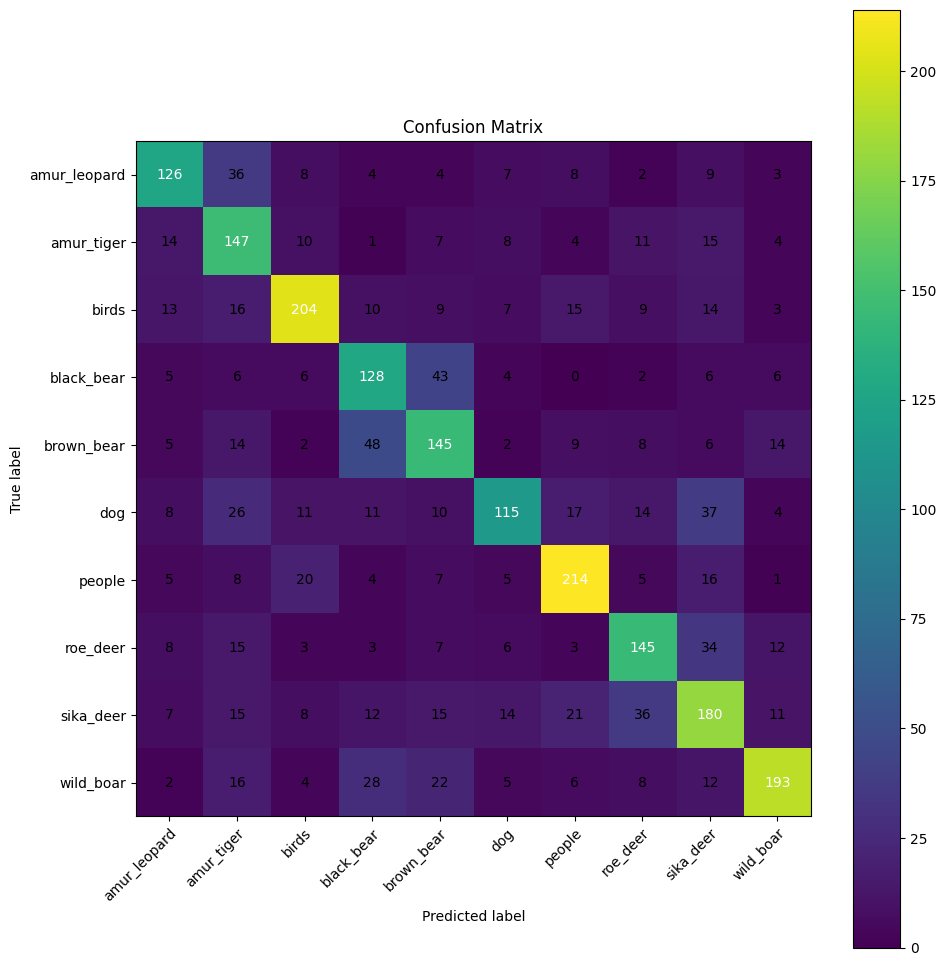

In [32]:
# plot the confusion matrix for the test set
plotting_confusion_matrix(test_dataloader, f"A1_Q2_CNN_Experiment_{run_num}_Confusion_Matrix")

#### Analysing the misclassified images (BONUS)

In [33]:
# find misclassified images and print 3 misclassified images for each class
def misclassified_images(dataloader):
    misclassified_images = {i: [] for i in range(len(dataset.classes))}
    for i, sample in enumerate(dataloader, 0):
        image = sample['image']
        label = sample['label']
        image = image.to(device)
        label = torch.tensor(label).to(device)
        forwards = model.forward(image)
        logits = F.softmax(forwards, dim=1)
        pred = torch.argmax(logits, dim=1)
        label = int(label.cpu().numpy())
        pred = int(pred.cpu().numpy())
        if (label != pred):
            if (len(misclassified_images[label]) < 3):
                misclassified_images[label].append([image, label, pred])
    return misclassified_images

misclassified_images = misclassified_images(test_dataloader)

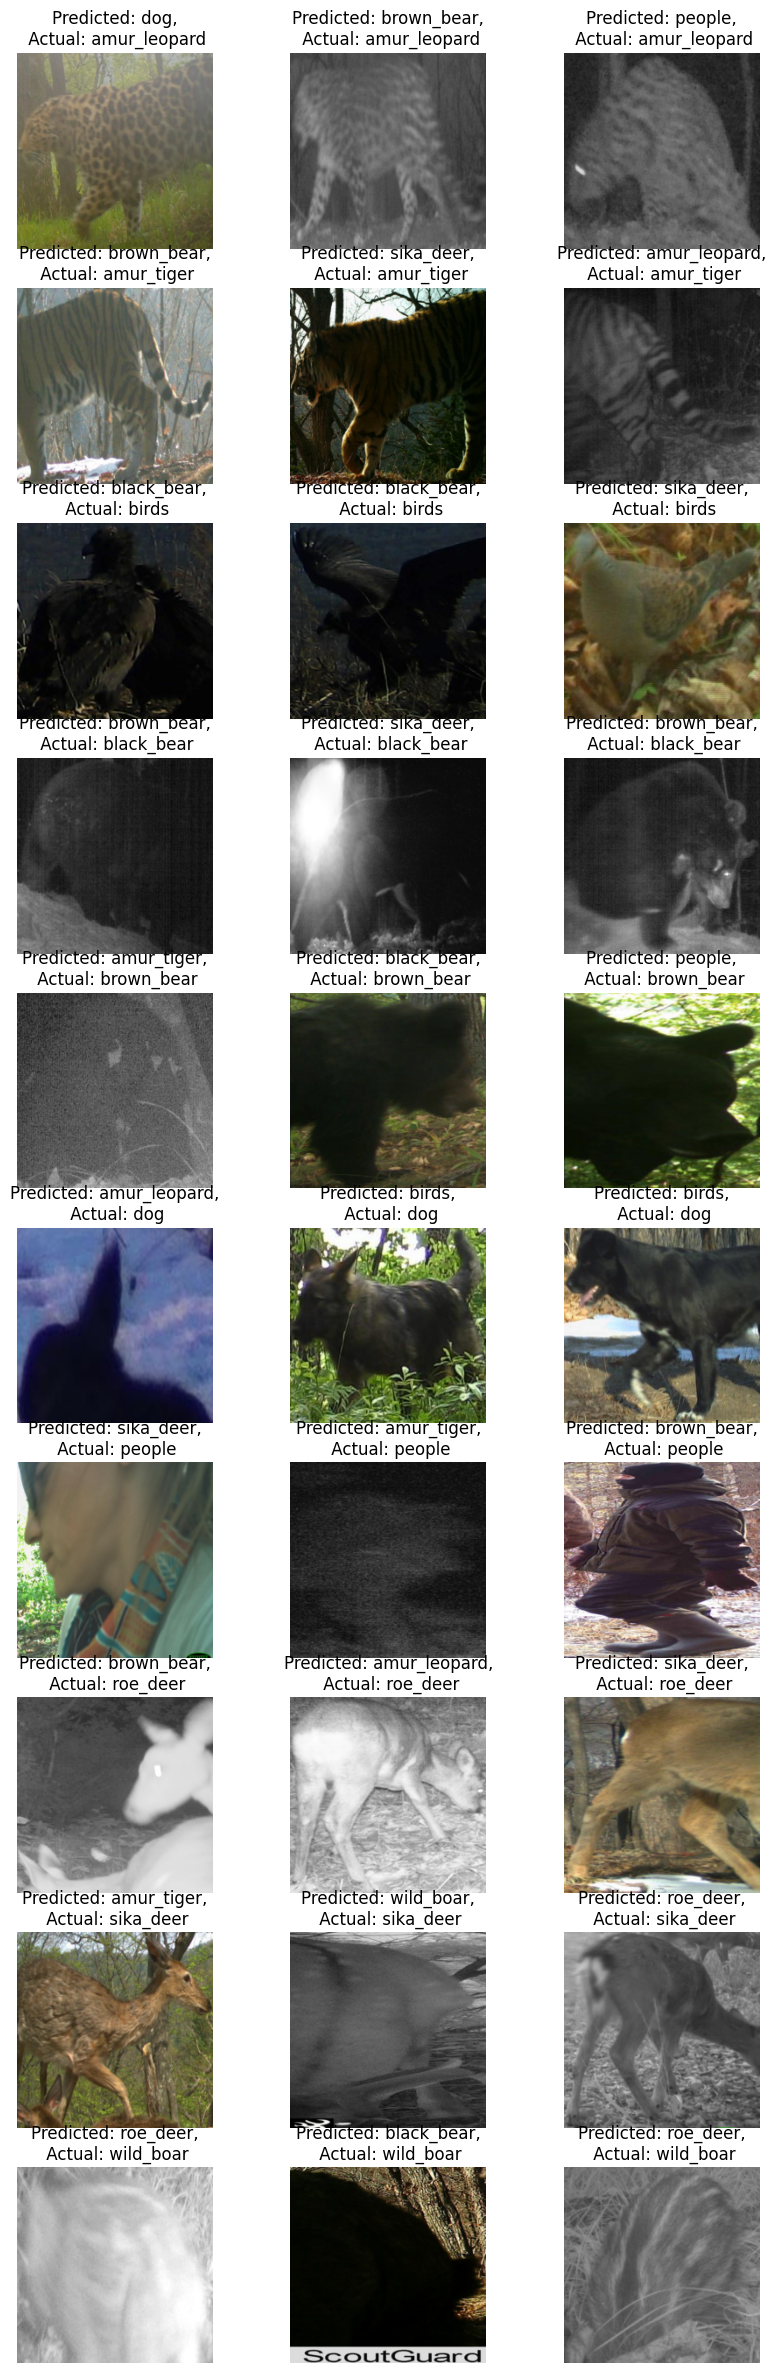

In [34]:
# plot the misclassified images
fig, axes = plt.subplots(len(dataset.classes), 3, figsize=(10, 30))
for i in range(len(dataset.classes)):
    for j in range(3):
        image = transforms.ToPILImage()((((misclassified_images[i][j][0]+1)/2) * 255).squeeze().to(torch.uint8))
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"Predicted: {dataset.get_class_name(misclassified_images[i][j][2])},\n Actual: {dataset.get_class_name(misclassified_images[i][j][1])}")
        axes[i, j].axis('off')
plt.show()

In [36]:
torch.save(model.state_dict(), f"A1_Q2_CNN_Experiment_{run_num}.pth")

In [37]:
wandb.finish()

## Q2.3 Fine-tuning a pre-trained model

In [ ]:
print(os.getcwd())
print(.)

In [ ]:
resnet18_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_size = 0.7
val_size = 0.1
test_size = 0.2
batch_size = 16
run_num = 1

In [ ]:
dataset = RussianWildLifeDataset(new_path, composed_transform)

In [ ]:
class_wise_indices = [np.where(np.array(dataset.labels) == i)[0] for i in range(len(dataset.classes))]
class_distribution = [len(indices) for indices in class_wise_indices]
train_class_distribution = [int(train_size * dist) for dist in class_distribution]
val_class_distribution = [int(val_size * dist) for dist in class_distribution]
test_class_distribution = [int(test_size * dist) for dist in class_distribution]

In [ ]:
train_indices = []
val_indices = []
test_indices = []
for i in range(len(dataset.classes)):
    np.random.shuffle(class_wise_indices[i])
    train_indices.extend(class_wise_indices[i][:train_class_distribution[i]])
    val_indices.extend(class_wise_indices[i][train_class_distribution[i]:train_class_distribution[i]+val_class_distribution[i]])
    test_indices.extend(class_wise_indices[i][train_class_distribution[i]+val_class_distribution[i]:])

In [ ]:
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)
print(train_size, val_size, test_size)

In [ ]:
print(os.getcwd())
os.chdir("..")
os.chdir("..")
print(os.getcwd())

In [ ]:
import wandb
wandb.login()

In [ ]:
model_config = dict(
    epochs=10,
    classes=10,
    batch_size=batch_size,
    optimizer="Adam",
    learning_rate=0.001,
    dataset="Russian WildLife Dataset",
    architecture="Resnet18", 
    data_augmentation="False",
    weight_initialisation="Default")

In [ ]:
wandb.init(
    project = "Computer_Vision_A1",
    config = model_config,
)

In [ ]:
data_visualization(train_data)

In [ ]:
data_visualization(val_data)

In [ ]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
optimizer = optim.Adam(model.parameters())

In [ ]:
wandb.watch(model)

In [ ]:
def train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader):
    running_loss = 0.0
    model.train()
    for epoch in range(model_config['epochs']):
        for i, sample in enumerate(train_dataloader, 0):
            inputs = sample['image']
            labels = sample['label']
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)
            # zero the gradients before backprop
            optimizer.zero_grad()
            # forward pass
            logits = model.forward(inputs)
            loss = loss_fn(logits, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            minibatch_loss = loss.item()
            running_loss += minibatch_loss
            # logging the minibatch after every batch, and running loss after every 100 minibatches
            wandb.log({'minibatch_loss': minibatch_loss})
            if (i%100==0):
                wandb.log({'running_loss': running_loss / 100})
                running_loss = 0.0
        # log the training accuracy and loss
        correct, total, loss = loss_acc_calc(train_dataloader)
        wandb.log({'train_loss': loss / len(train_dataloader), 'train_accuracy': (correct / total) * 100.0})
        # log the validation accuracy and loss
        correct, total, loss = loss_acc_calc(val_dataloader)
        wandb.log({'val_loss': loss / len(val_dataloader), 'val_accuracy': (correct / total) * 100.0})
    # save the model after training
    torch.save(model.state_dict(), f"A1_Q2_ConvNet_Experiment_{run_num}.pth")
    return model

In [ ]:
loss_acc_calc(val_dataloader)

In [ ]:
loss_acc_calc(test_dataloader)

In [ ]:
model = train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader)

In [ ]:
# testing the model 
correct, total, loss = loss_acc_calc(test_dataloader)
print(f"Test Accuracy: {(correct / total) * 100.0}%")
wandb.log({'test_accuracy': (correct / total) * 100.0})
# calculate the metrics
y_true, y_pred = evaluation_metris_calc(test_dataloader)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
# logging the metrics onto wandb
wandb.run.summary["test_accuracy"] = (correct / total) * 100.0
wandb.run.summary["f1_score"] = f1
wandb.run.summary["precision"] = precision
wandb.run.summary["recall"] = recall

In [ ]:
wandb.finish()

In [ ]:
# plot the confusion matrix for the test set
plotting_confusion_matrix(test_dataloader, f"A1_Q2_ResNet_Experiment_{run_num}_Confusion_Matrix")

In [ ]:
misclassified_images = misclassified_images(test_dataloader)